# Shapefile Integration

Now, we can try to make sense of some shapefiles and get them into a format where we can apply our algorithm. First, let's install a library that allows us to work easily with shapefiles! I chose `pyshp`.

In [33]:
!pip install pyshp

In [ ]:
import shapefile
import geopandas as gpd
import os

Now we can load in our shapefile and set up our reader.

In [172]:
myshp = open("C:\\Users\\Mark\\Desktop\\coastline-capstone\\LA_shorelines.shp", "rb")
mydbf = open("C:\\Users\\Mark\\Desktop\\coastline-capstone\\LA_shorelines.dbf", "rb")

r = shapefile.Reader(shp=myshp, dbf=mydbf)
shapes = r.shapes()

Just to get a sense of what this shapefile looks like, we can plot each shape.

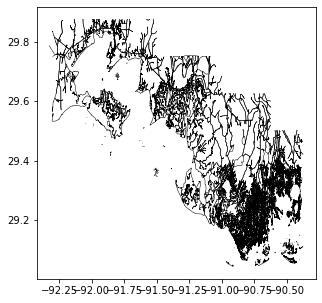

In [173]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,figsize=(5,5))
x_curves = []
y_curves = []
for shape in r.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    x_curves.append(x[0])
    x_curves.append(x[1])
    y = [i[1] for i in shape.shape.points[:]]
    y_curves.append(y[0])
    y_curves.append(y[1])
    ax.plot(x,y, 'k', linewidth='0.5')

In [174]:
x_offset = min(x_curves)
y_offset = min(y_curves)

Now, we can do some transformations on the coordinates to make them more usable for our purposes. Since the coordinates have a lot of decimals and our 2D array approach requires integer coordinates, we can multiply each coordinate by some amount and round off the excess.

In [175]:
shape_coords = []
for shape in shapes:
    shape_coords.append(shape.bbox)

In [176]:
rounded_coords = []
for bbox in shape_coords:
    bbox = list(map(lambda x: round(x*1000), bbox))
    rounded_coords.append(bbox)

Each shape is given as a boundary box - to simplify this, we can individually average the x values and the y values of each boundary box. Now that we have our integer coordinates, we can start creating our 2D array from this shapefile. First, let's store the x and y values separately - it will be useful!

In [177]:
avg_x_coords = []
avg_y_coords = []
avg_coords = []
for point in rounded_coords:
    x = (point[0]+point[2])//2
    y = (point[1]+point[3])//2
    avg_x_coords.append(x)
    avg_y_coords.append(y)
    avg_coords.append([x,y])

We can now easily discern the necessary dimensions for our 2D array.

In [178]:
x_range = max(avg_x_coords) - min(avg_x_coords)
y_range = max(avg_y_coords) - min(avg_y_coords)

Making the array itself...

In [179]:
coast = [[0 for i in range(y_range+1)] for j in range(x_range+1)]

Next, we can subtract from each coordinate to equalize the bottom-right corner of our plot at the origin.

In [180]:
for point in avg_coords:
    point[0] -= min(avg_x_coords)
    point[1] -= min(avg_y_coords)

Finally, we can populate our 2D array with land data.

In [181]:
for point in avg_coords:
    coast[point[0]][point[1]] = 1

Below are constants used to transform the plot to the same proportions as our coastline plot.

In [182]:
xq = max(x_curves)-x_offset
yq = max(y_curves)-y_offset

In [183]:
coast = [[0 for i in range(y_range+1)] for j in range(x_range+1)]
for point in avg_coords:
    coast[point[0]][point[1]] = 1

Now let's plant some trees! We can introduce our functions from the `erosion_model` notebook. (Giant cell, but nothing new.)

In [184]:
import numpy as np

def timestep(coast):
    for row_idx in range(len(coast)): # loops to check every element
        for col_idx in range(len(coast[row_idx])): # in the 2d array.
            if coast[row_idx][col_idx] > 0: # if there is land, begin the coast checks
                # the coast checks are partitioned in this way to prevent index errors!
                # the top row checks only the left and right points
                if row_idx != 0:
                    if coast[row_idx-1][col_idx] <= 0:
                        if treemap[row_idx-1][col_idx]:
                            coast[row_idx][col_idx] -= 0.01
                        else:
                            coast[row_idx][col_idx] -= 0.16
                # the leftmost column checks only the right and front points
                if col_idx != 0:
                    if coast[row_idx][col_idx-1] <= 0:
                        if treemap[row_idx][col_idx-1]:
                            coast[row_idx][col_idx] -= 0.01
                        else:
                            coast[row_idx][col_idx] -= 0.06
                # the rightmost column checks only the left and front points
                if col_idx != len(coast[0])-1:
                    if coast[row_idx][col_idx+1] <= 0:
                        if treemap[row_idx][col_idx+1]:
                            coast[row_idx][col_idx] -= 0.01
                        else:
                            coast[row_idx][col_idx] -= 0.06
                
                if coast[row_idx][col_idx] < 0:  # fixes over-subtraction
                    coast[row_idx][col_idx] = 0
                    
def graphical_timestep(coast):
    timestep(coast)
    for row in range(len(coast)):
        for col in range(len(coast[0])):
            if coast[row][col] > 0:
                points[(row,col)].set_radius(5*coast[row][col]*0.8)
            
treemap = np.zeros((len(coast), len(coast[0])), dtype=bool)

def num_faces(coast, row, col):
    faces = 0
    if coast[row][col] == 0:
        if row-1 >= 0:
            if coast[row-1][col] > 0:
                faces += 1
        if row+1 <= len(coast)-1:
            if coast[row+1][col] > 0:
                faces += 1
        if col-1 >= 0:
            if coast[row][col-1] > 0:
                faces += 1
        if col+1 <= len(coast[0])-1:
            if coast[row][col+1] > 0:
                faces += 1
    return faces

def place_trees(coast, treemap, n):
    trees_to_place = n
    
    # first, check for four open faces (only possible with a mini lake, but still)
    for row_idx in range(len(coast)): # loops to check every element
        for col_idx in range(len(coast[row_idx])): # in the 2d array.
            if num_faces(coast,row_idx,col_idx) == 4:
                treemap[row_idx][col_idx] = True
                trees_to_place -= 1
                # also, we need to ensure we don't overplant.
                # check if we have any trees left after every planting -
                # if not, break immediately.
                if trees_to_place == 0:
                    return
    
    # next, check for three open faces.
    for row_idx in range(len(coast)): # loops to check every element
        for col_idx in range(len(coast[row_idx])): # in the 2d array.
            if num_faces(coast,row_idx,col_idx) == 3:
                treemap[row_idx][col_idx] = True
                trees_to_place -= 1
                if trees_to_place == 0:
                    return
    
    # now two open faces...
    for row_idx in range(len(coast)): # loops to check every element
        for col_idx in range(len(coast[row_idx])): # in the 2d array.
            if num_faces(coast,row_idx,col_idx) == 2:
                treemap[row_idx][col_idx] = True
                trees_to_place -= 1
                if trees_to_place == 0:
                    return
                
    # and one open face.
    for row_idx in range(len(coast)): # loops to check every element
        for col_idx in range(len(coast[row_idx])): # in the 2d array.
            if num_faces(coast,row_idx,col_idx) == 1:
                treemap[row_idx][col_idx] = True
                trees_to_place -= 1
                if trees_to_place == 0:
                    return

# Running the Tree-Planting Algorithm

Let's start with 200 trees.

In [185]:
coast = [[0 for i in range(y_range+1)] for j in range(x_range+1)]
for point in avg_coords:
    coast[point[0]][point[1]] = 1
treemap = np.zeros((len(coast), len(coast[0])), dtype=bool)
    
place_trees(coast,treemap,200)

(-20.0, 151.0)

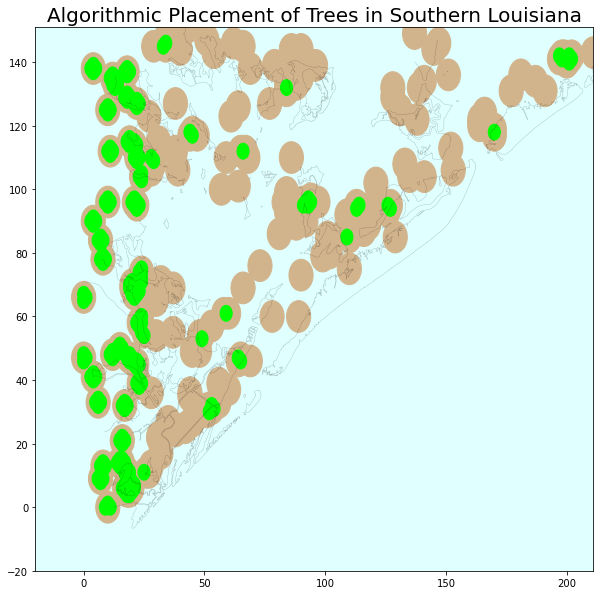

In [199]:
fig, ax = plt.subplots(1,figsize=(10,10))
points = {}
            
ax.set_facecolor('lightcyan')
            
for row in range(len(coast)):
    for col in range(len(coast[0])):
        if coast[row][col] == 1:
            p = mpatches.Circle((row, col), coast[row][col]*5, color="tan") # key = coords, val = patch object
            points[(row,col)] = p
            ax.add_patch(p)

for shape in r.shapeRecords():
    x = [(i[0]-x_offset)*(x_range/xq) for i in shape.shape.points[:]]
    y = [(i[1]-y_offset)*(y_range/yq) for i in shape.shape.points[:]]
    ax.plot(x,y, 'k', linewidth='0.35', alpha=0.3)

for row in range(len(coast)):
    for col in range(len(coast[0])):         
        if treemap[row][col]:
            t = mpatches.Circle((row, col), 2.5, color="lime")
            ax.add_patch(t)
            
plt.title('Algorithmic Placement of Trees in Southern Louisiana', fontsize="20")

plt.xlim([-20,x_range])
plt.ylim([-20,y_range])

The algorithm seems to work quite nicely!

# Measuring Efficacy

We can add a function to quickly perform multiple timesteps in order to streamline area comparisons.

In [187]:
def multi_step(coast, area_array, n):
    for _ in range(n):
        timestep(coast)
        area_array.append(np.sum(coast))

Just to see what sort of difference this placement makes, we can run a treeless simulation. Resetting the coast and tree arrays to their initial states:

In [188]:
coast = [[0 for i in range(y_range+1)] for j in range(x_range+1)]
for point in avg_coords:
    coast[point[0]][point[1]] = 1
treemap = np.zeros((len(coast), len(coast[0])), dtype=bool)

Now, we can take a few timesteps in each simulation and tally the area as it decreases.

In [189]:
notree_area = [np.sum(coast)]
area_prog = [np.sum(coast)]

In [190]:
multi_step(coast, notree_area, 5)
notree_area

[10435,
 8007.439999999999,
 5579.880000000001,
 3152.3199999999993,
 1414.1599999999996,
 812.5599999999996]

In [191]:
coast = [[0 for i in range(y_range+1)] for j in range(x_range+1)]
for point in avg_coords:
    coast[point[0]][point[1]] = 1

In [192]:
place_trees(coast,treemap,200)
multi_step(coast,area_prog,5)
area_prog

[10435,
 8048.739999999999,
 5662.48,
 3276.219999999999,
 1566.04,
 971.2799999999994]

### In our simulation, the placement of trees reduces coastal erosion nearly tenfold.

Text(0.5, 0, 'Timestep number')

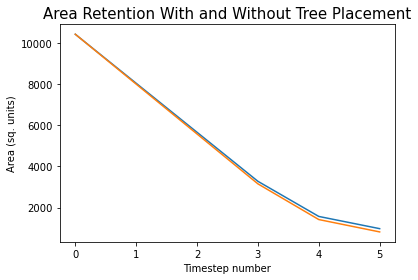

In [200]:
plt.figure()
plt.plot(area_prog)
plt.plot(notree_area)
plt.title("Area Retention With and Without Tree Placement", fontsize=15)
plt.ylabel("Area (sq. units)")
plt.xlabel("Timestep number")

# Additional Plots in Other Areas

This process will produce a simulation for any compatible shapefile. Below are a few others in areas of Louisiana such as Houma and the greater Grand Isle area. (This gigantic cell simply reruns the setup functions)

(-20.0, 823.0)

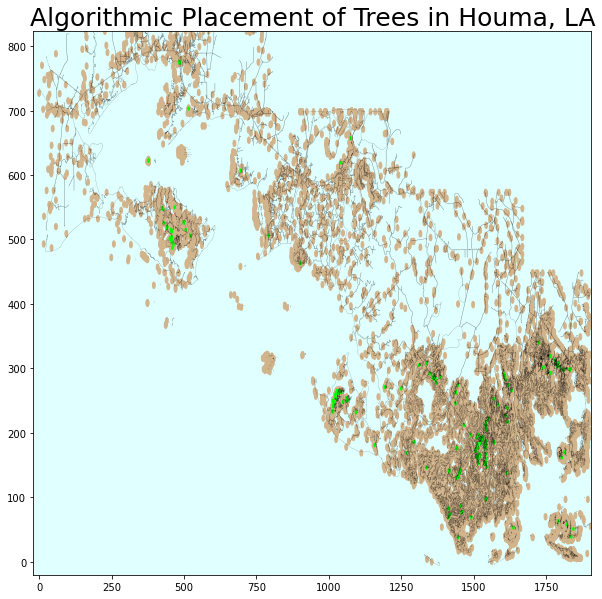

In [202]:
newshp = open("C:\\Users\\Mark\\Desktop\\coastline-capstone\\Houma Shapefile\\HoumaShapfile.shp", "rb")
newdbf = open("C:\\Users\\Mark\\Desktop\\coastline-capstone\\Houma Shapefile\\HoumaShapfile.dbf", "rb")

r = shapefile.Reader(shp=newshp, dbf=newdbf)
shapes = r.shapes()

x_curves = []
y_curves = []
for shape in r.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    x_curves.append(x[0])
    x_curves.append(x[1])
    y = [i[1] for i in shape.shape.points[:]]
    y_curves.append(y[0])
    y_curves.append(y[1])

x_offset = min(x_curves)
y_offset = min(y_curves)

shape_coords = []
for shape in shapes:
    shape_coords.append(shape.bbox)

rounded_coords = []
for bbox in shape_coords:
    bbox = list(map(lambda x: round(x*1000), bbox))
    rounded_coords.append(bbox)

avg_x_coords = []
avg_y_coords = []
avg_coords = []

for point in rounded_coords:
    x = (point[0]+point[2])//2
    y = (point[1]+point[3])//2
    avg_x_coords.append(x)
    avg_y_coords.append(y)
    avg_coords.append([x,y])

x_range = max(avg_x_coords) - min(avg_x_coords)
y_range = max(avg_y_coords) - min(avg_y_coords)

for point in avg_coords:
    point[0] -= min(avg_x_coords)
    point[1] -= min(avg_y_coords)

coast = [[0 for i in range(y_range+1)] for j in range(x_range+1)]

for point in avg_coords:
    coast[point[0]][point[1]] = 1

xq = max(x_curves)-x_offset
yq = max(y_curves)-y_offset


treemap = np.zeros((len(coast), len(coast[0])), dtype=bool)
place_trees(coast,treemap,1000)

fig, ax = plt.subplots(1,figsize=(10,10))
points = {} 
            
ax.set_facecolor('lightcyan')
            
for row in range(len(coast)):
    for col in range(len(coast[0])):
        if coast[row][col] == 1:
            p = mpatches.Circle((row, col), coast[row][col]*5, color="tan") # key = coords, val = patch object
            points[(row,col)] = p
            ax.add_patch(p)

for shape in r.shapeRecords():
    x = [(i[0]-x_offset)*(x_range/xq) for i in shape.shape.points[:]]
    y = [(i[1]-y_offset)*(y_range/yq) for i in shape.shape.points[:]]
    ax.plot(x,y, 'k', linewidth='0.35', alpha=0.3)

for row in range(len(coast)):
    for col in range(len(coast[0])):         
        if treemap[row][col]:
            t = mpatches.Circle((row, col), 2.5, color="lime")
            ax.add_patch(t)
            
plt.title('Algorithmic Placement of 1000 Trees in Houma, LA', fontsize='23')

plt.xlim([-20,x_range])
plt.ylim([-20,y_range])

(-20.0, 1085.0)

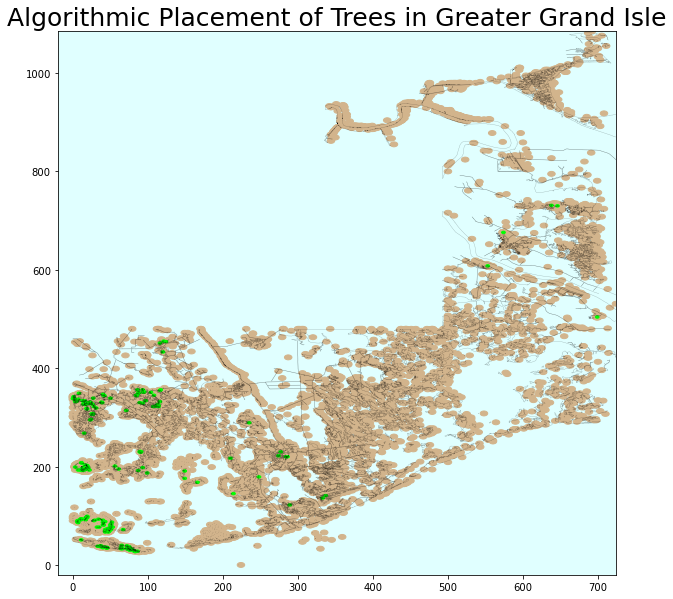

In [201]:
newshp = open("C:\\Users\\Mark\\Desktop\\coastline-capstone\\SouthernLouisiana(GrandIsle)FilteredShapfile.shp", "rb")
newdbf = open("C:\\Users\\Mark\\Desktop\\coastline-capstone\\SouthernLouisiana(GrandIsle)FilteredShapfile.dbf", "rb")

r = shapefile.Reader(shp=newshp, dbf=newdbf)
shapes = r.shapes()

x_curves = []
y_curves = []
for shape in r.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    x_curves.append(x[0])
    x_curves.append(x[1])
    y = [i[1] for i in shape.shape.points[:]]
    y_curves.append(y[0])
    y_curves.append(y[1])

x_offset = min(x_curves)
y_offset = min(y_curves)

shape_coords = []
for shape in shapes:
    shape_coords.append(shape.bbox)

rounded_coords = []
for bbox in shape_coords:
    bbox = list(map(lambda x: round(x*1000), bbox))
    rounded_coords.append(bbox)

avg_x_coords = []
avg_y_coords = []
avg_coords = []

for point in rounded_coords:
    x = (point[0]+point[2])//2
    y = (point[1]+point[3])//2
    avg_x_coords.append(x)
    avg_y_coords.append(y)
    avg_coords.append([x,y])

x_range = max(avg_x_coords) - min(avg_x_coords)
y_range = max(avg_y_coords) - min(avg_y_coords)

for point in avg_coords:
    point[0] -= min(avg_x_coords)
    point[1] -= min(avg_y_coords)

coast = [[0 for i in range(y_range+1)] for j in range(x_range+1)]

for point in avg_coords:
    coast[point[0]][point[1]] = 1

xq = max(x_curves)-x_offset
yq = max(y_curves)-y_offset


treemap = np.zeros((len(coast), len(coast[0])), dtype=bool)
place_trees(coast,treemap,1000)

fig, ax = plt.subplots(1,figsize=(10,10))
points = {} 
            
ax.set_facecolor('lightcyan')
            
for row in range(len(coast)):
    for col in range(len(coast[0])):
        if coast[row][col] == 1:
            p = mpatches.Circle((row, col), coast[row][col]*5, color="tan") # key = coords, val = patch object
            points[(row,col)] = p
            ax.add_patch(p)

for shape in r.shapeRecords():
    x = [(i[0]-x_offset)*(x_range/xq) for i in shape.shape.points[:]]
    y = [(i[1]-y_offset)*(y_range/yq) for i in shape.shape.points[:]]
    ax.plot(x,y, 'k', linewidth='0.35', alpha=0.3)

for row in range(len(coast)):
    for col in range(len(coast[0])):         
        if treemap[row][col]:
            t = mpatches.Circle((row, col), 2.5, color="lime")
            ax.add_patch(t)
            
plt.title('Algorithmic Placement of 1000 Trees in Greater Grand Isle', fontsize=23)

plt.xlim([-20,x_range])
plt.ylim([-20,y_range])